## Second order stationarity

The example below corresponds to examples 1.9 and 1.10 from Shumway and Stoffer. It shows how to create MA and AR series based on white noise using the `filter` function. It is best practice when simulating autoregressive models to burn-in (discard) the first few iterations to remove the dependencies on the starting values (here zeros). Note that the function `filter` returns a `ts` object.

In [1]:
set.seed(1)
x <- rnorm(550, 0, 1)  # Samples from N(0,1) variates
y <- filter(x, method = "recursive", filter = c(1, -0.9))  #autoregression
z <- filter(x, method = "convolution", filter = rep(1/3, 3), sides = 2)  # moving average
class(z)

[1] "ts"

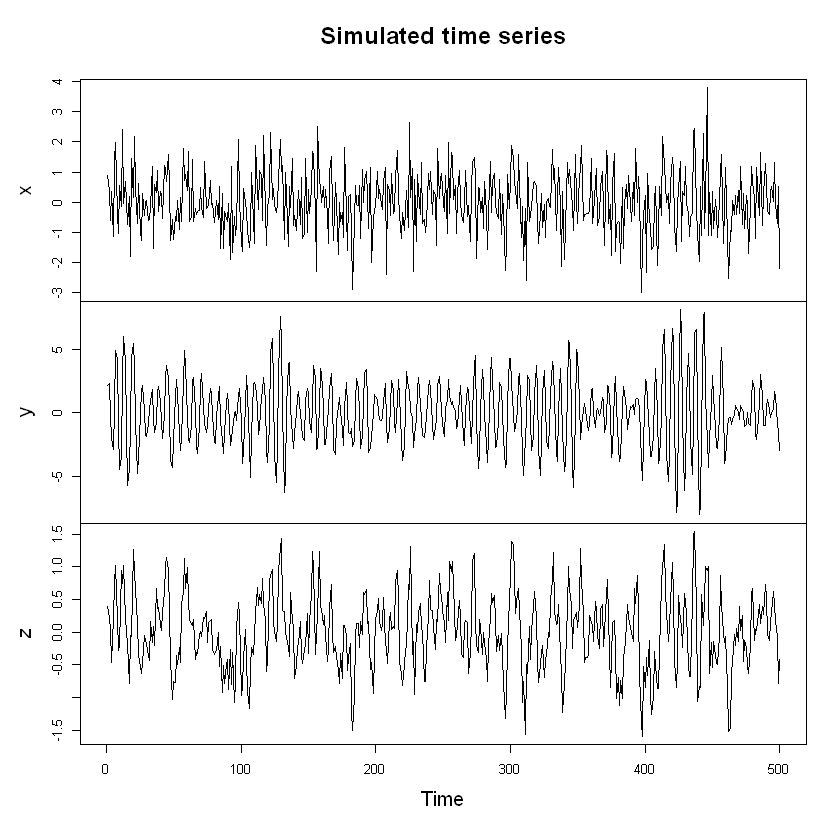

In [2]:
x <- x[-c(1:49, 550)]
y <- y[-c(1:49, 550)]
z <- z[-c(1:49, 550)]
# ts.union if we did not remove values (and the class `ts`)
plot.ts(cbind(x, y, z), main = "Simulated time series")

We notice immediately that the MA process looks smoother than the white noise, and that the innovations (peaks) of the AR process are longer lasting. If we had not simulated more values and kept some, the first and last observations of `z` would be `NA`s. The series created are of the form

$$ z_{t} = \frac{1}{3}(x_{t-1} + x_{t} + x_{t+1}) $$

and 

$$ y_{t} = y_{t-1} - 0.9 y_{t-2} + x_{t} $$

The correlogram provides an easy to use summary for detecting *linear*  dependencies based on correlations. The function `acf` will return a plot of the correlogram, by default using the correlation. Unfortunately, the basic graph starts at lag 1, which by default has correlation 1 and thus compress the whole plot unnecessarily. Blue dashed lines indicate 5% critical values at ±1.96/√n under the null hypothesis of white noise (not stationarity).

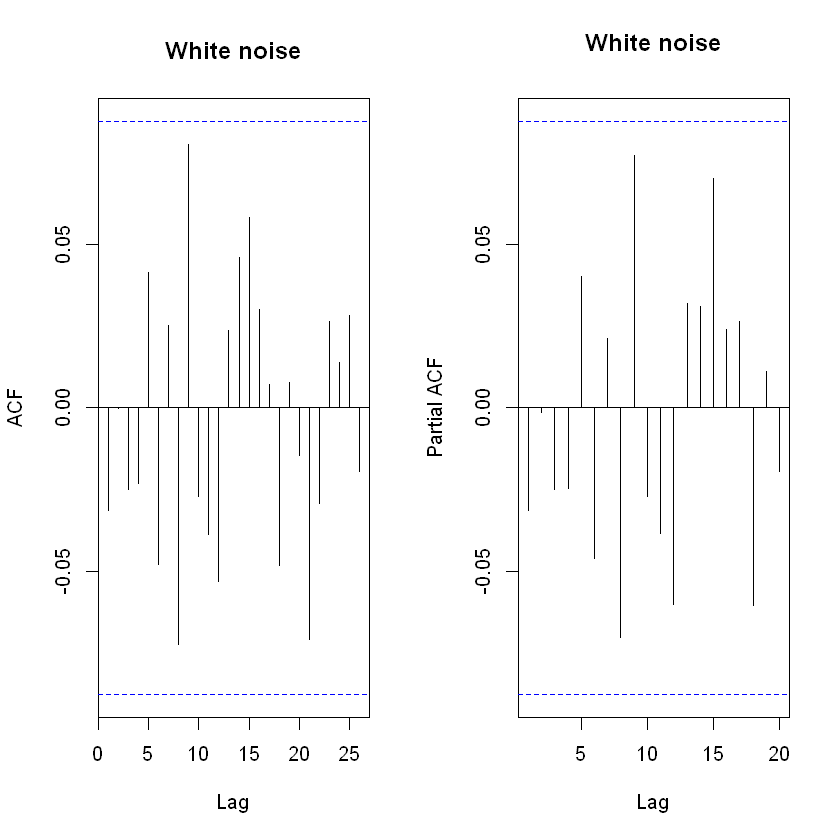

In [8]:
# acf(x, lag.max=20, demean = TRUE, main = 'White noise') #WRONG
par(mfrow = c(1, 2))
TSA::acf(x, demean = TRUE, main = "White noise")
pacf(x, lag.max = 20, main = "White noise")

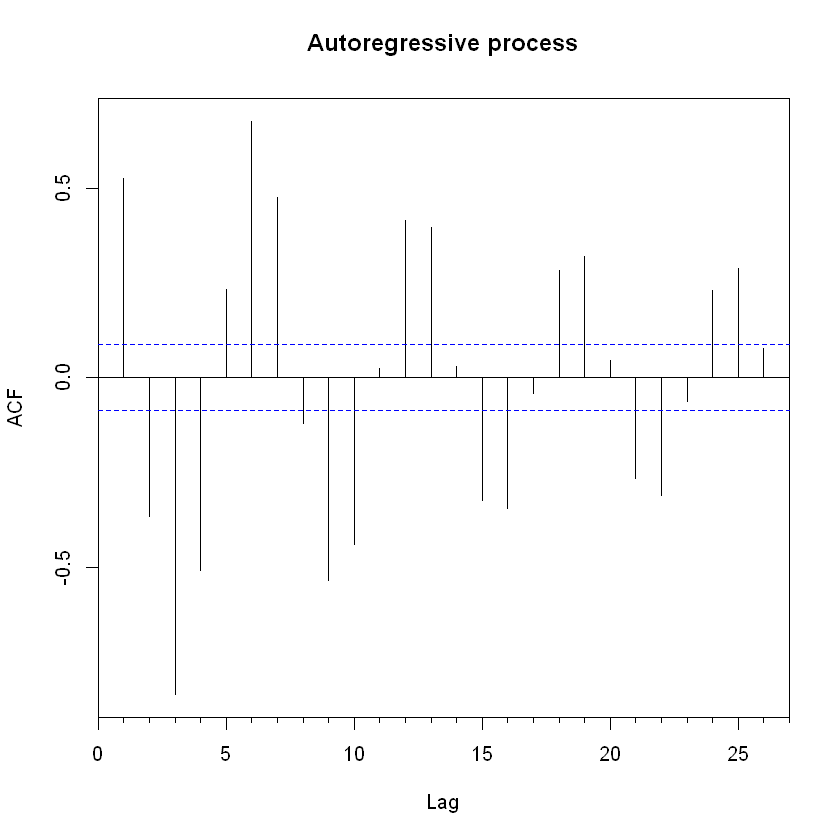

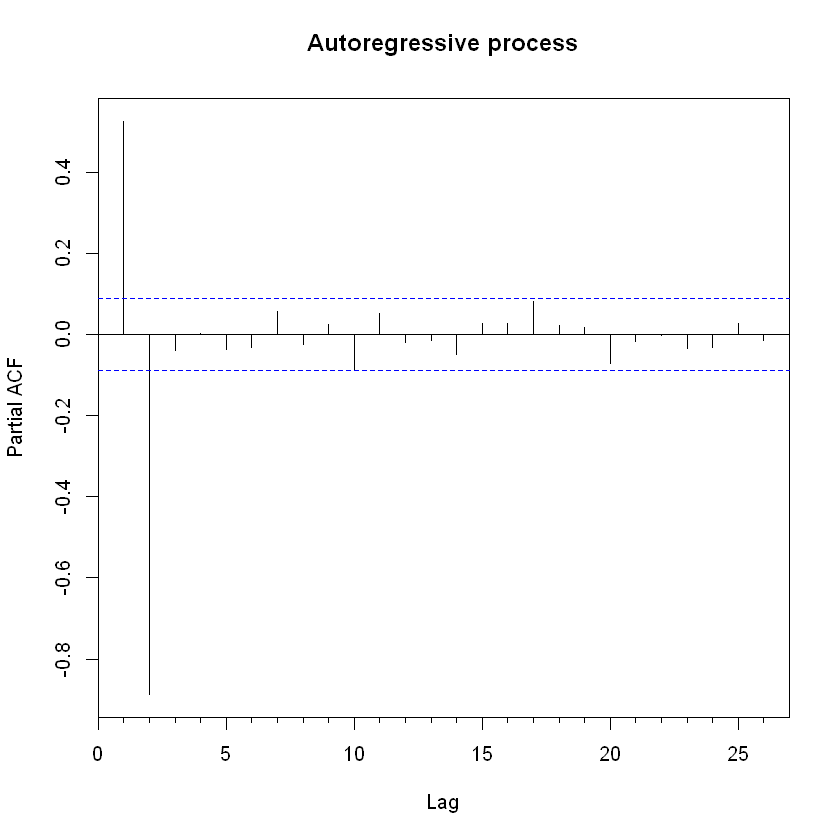

In [9]:
# Equivalent functions from forecast
forecast::Acf(y, main = "Autoregressive process")
forecast::Acf(y, type = "partial", main = "Autoregressive process")  #or forecast::Pacf

You can thus use instead the function `forecast::Acf`, which removes the first lag of the autocorrelation function plot, or `TSA::acf`. The function `pacf` return the partial autocorrelations and the function `ccf` to compute the cross-correlation or cross-covariance of two univariate series

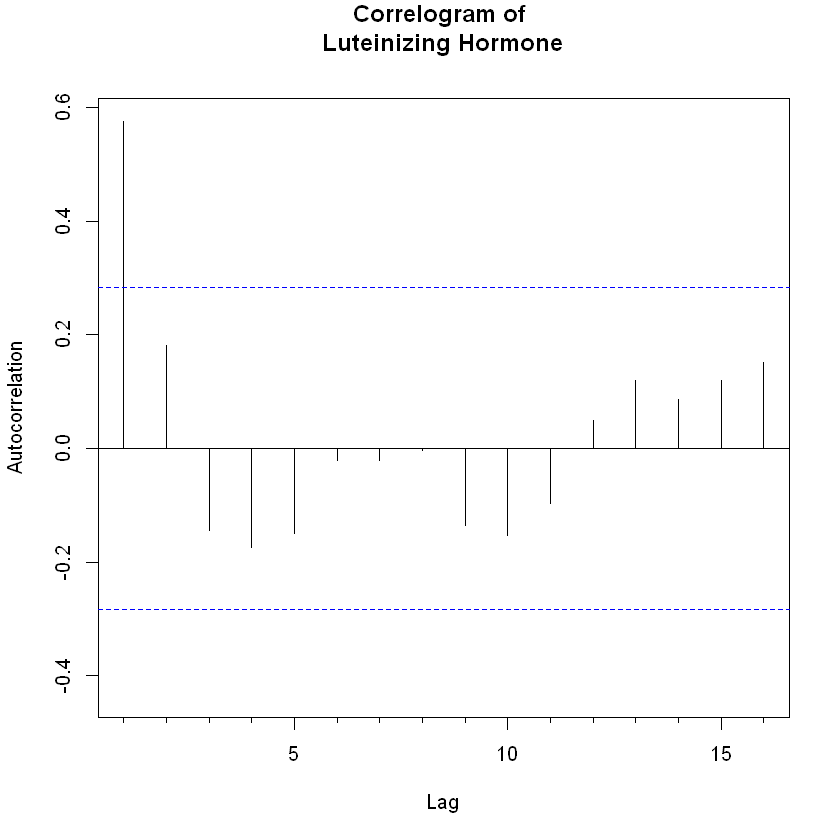

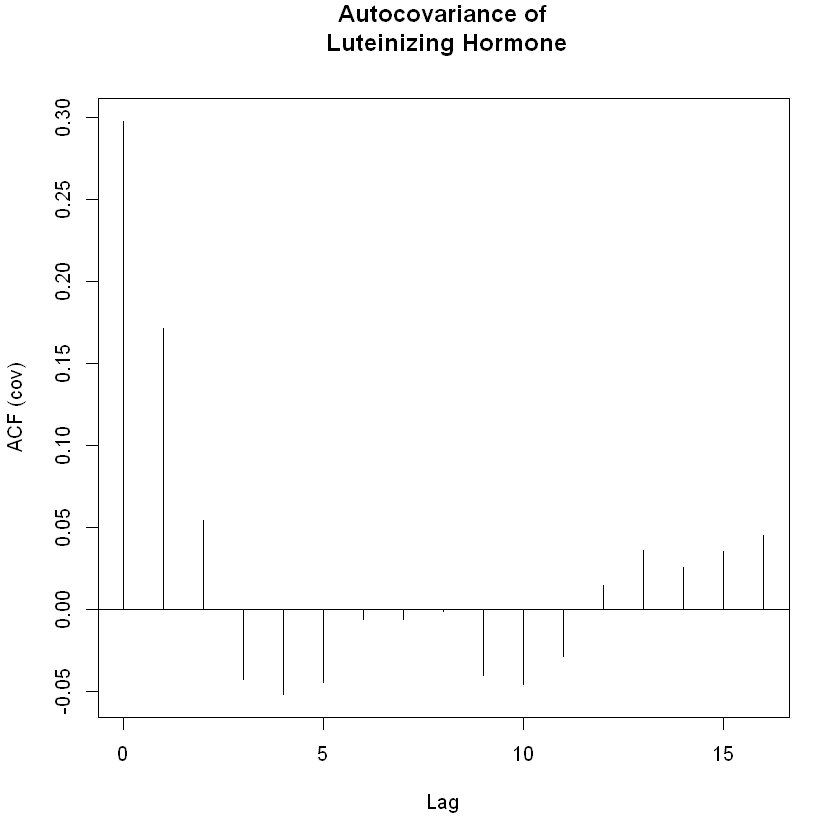

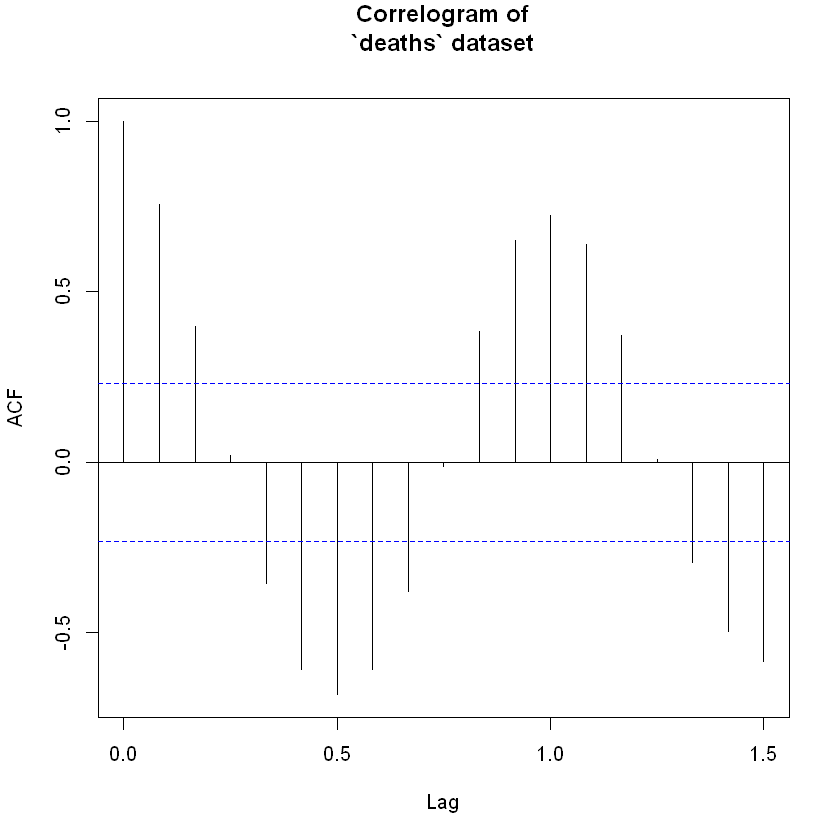

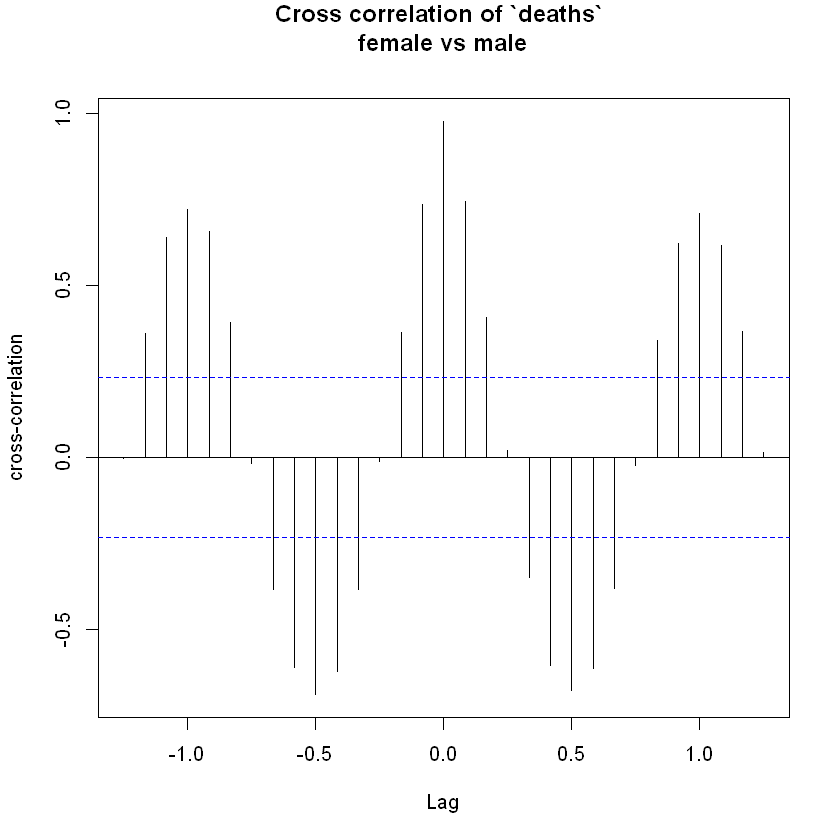

In [10]:
# Load datasets
data(deaths, package = "MASS")
data(lh, package = "datasets")
# Second order summaries
forecast::Acf(lh, main = "Correlogram of \nLuteinizing Hormone", ylab = "Autocorrelation")  #autocorrelation
acf(lh, type = "covariance", main = "Autocovariance of\n Luteinizing Hormone")  #autocovariance
acf(deaths, main = "Correlogram of\n`deaths` dataset")
ccf(fdeaths, mdeaths, ylab = "cross-correlation", main = "Cross correlation of `deaths` \nfemale vs male")
# acf(ts.union(mdeaths,fdeaths)) # acf and ccf - multiple time series of
# male and female deaths

The plots of the `deaths` series shows the pattern of seasonal series, and the autocorrelations do not damp down for large lags. Note how one of the cross series is only plotted for negative lags. Plot in row 2 column 1 shows c12 for negative lags, a reflection of the plot of c21 for positive lags. For the cross-correlation, use e.g.  `ccf(mdeaths, fdeaths, ylab="cross-correlation")`.

Plotting lagged residuals is a useful graphical diagnostic for detecting non-linear dependencies. The following function plots residuals at `k` different lags and may be useful for diagnostic purposes.

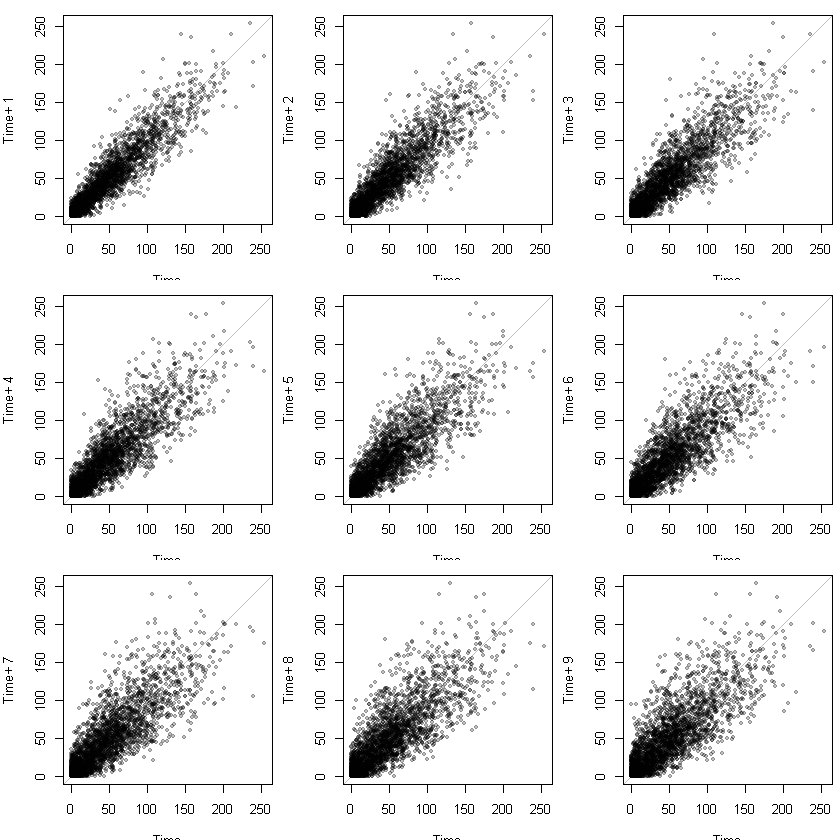

In [11]:
pairs.ts <- function(d, lag.max = 10) {
    old_par <- par(no.readonly = TRUE)
    n <- length(d)
    X <- matrix(NA, n - lag.max, lag.max)
    col.names <- paste("Time+", 1:lag.max)
    for (i in 1:lag.max) X[, i] <- d[i - 1 + 1:(n - lag.max)]
    par(mfrow = c(3, 3), pty = "s", mar = c(3, 4, 0.5, 0.5))
    lims <- range(X)
    for (i in 2:lag.max) plot(X[, 1], X[, i], panel.first = {
        abline(0, 1, col = "grey")
    }, xlab = "Time", ylab = col.names[i - 1], xlim = lims, ylim = lims, pch = 20, 
        col = rgb(0, 0, 0, 0.25))
    par(old_par)
}
# Look at lag k residuals
pairs.ts(sunspots)

### Exercise 2. SP500 daily returns
- Download the dataset using the following command
- Obtain the daily percent return series and plot the latter against time.
- With the help of graphs, discuss evidences of seasonality and nonstationarity. Are there seasons of returns?
- Plot the (partial) correlogram of both the raw and the return series. Try the acf with  na.action=na.pass and without (by e.g.   converting the series to a vector using as.vector. Comment on the impact of ignoring time stamps.
- Plot the (partial) correlogram of the absolute value of the return series and of the squared return series. What do you see?

In [13]:
sp500 <- tseries::get.hist.quote(instrument = "^GSPC", start = "2000-01-01", 
    end = "2016-12-31", quote = "AdjClose", provider = "yahoo", origin = "1970-01-01", 
    compression = "d", retclass = "zoo")

time series starts 2000-01-03
time series ends   2016-12-30


In [22]:
head(sp500)

           Adjusted
2000-01-03  1455.22
2000-01-04  1399.42
2000-01-05  1402.11
2000-01-06  1403.45
2000-01-07  1441.47
2000-01-10  1457.60

In [23]:
tail(sp500)

           Adjusted
2016-12-22  2260.96
2016-12-23  2263.79
2016-12-27  2268.88
2016-12-28  2249.92
2016-12-29  2249.26
2016-12-30  2238.83

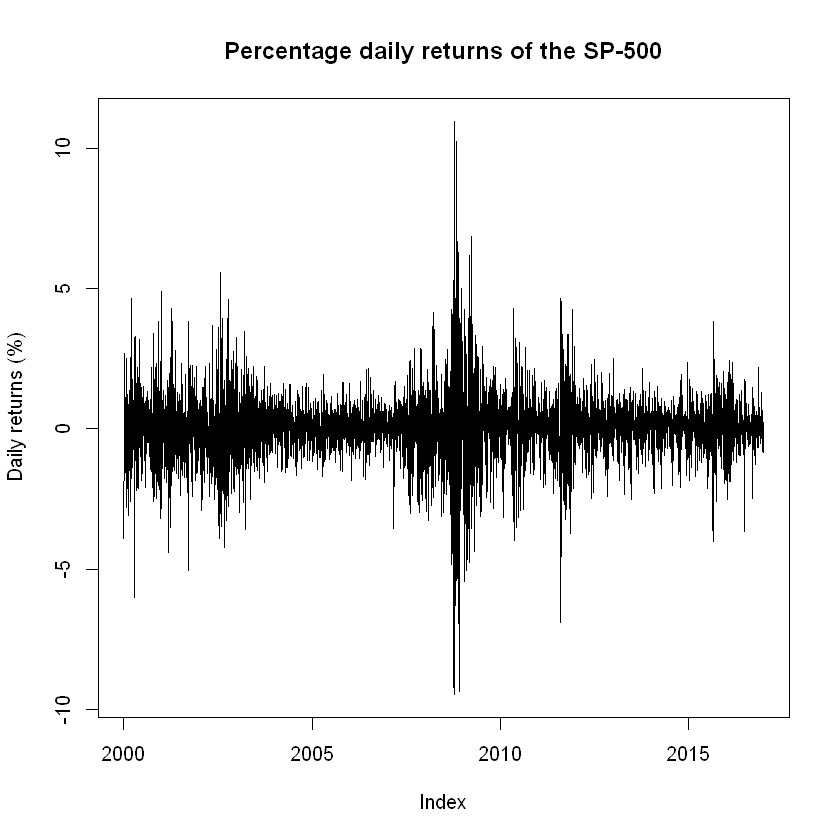

In [17]:
library(xts)
library(lubridate)
# Daily return in percentage
spret <- 100 * diff(log(sp500))
plot(spret, ylab = "Daily returns (%)", main = "Percentage daily returns of the SP-500")

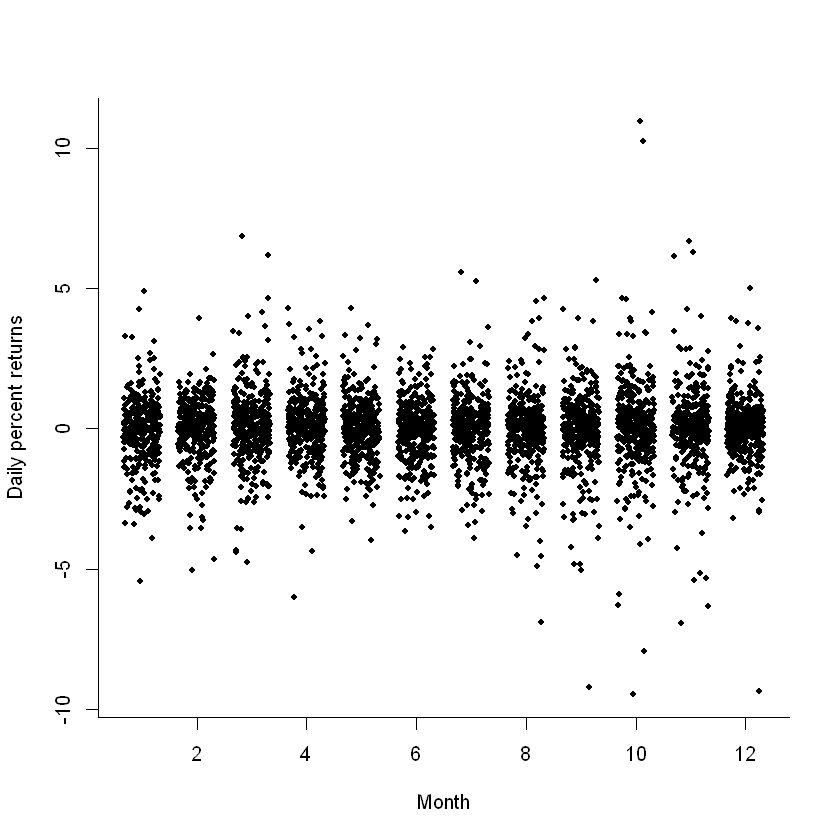

In [26]:
# Volatility as function of month
plot(jitter(month(spret), amount = 1/3), spret, pch = 20, ylab = "Daily percent returns", 
    xlab = "Month", bty = "l")

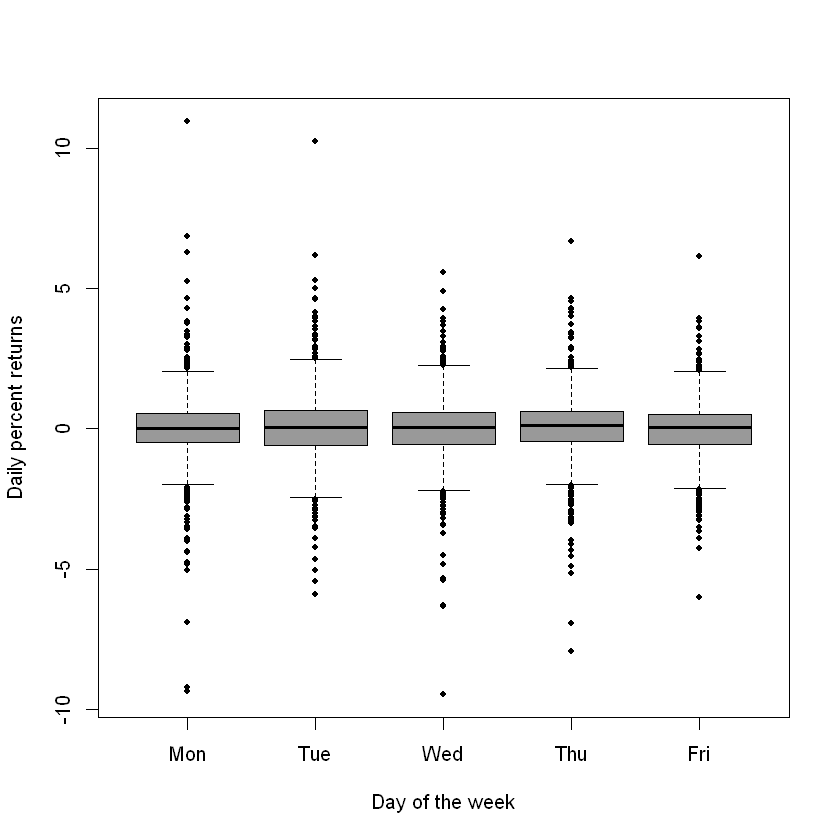

In [27]:
boxplot(as.vector(spret) ~ factor(wday(spret), labels = c("Mon", "Tue", "Wed", 
    "Thu", "Fri")), xlab = "Day of the week", pch = 20, col = rgb(0, 0, 0, 0.4), 
    ylab = "Daily percent returns", bty = "l")

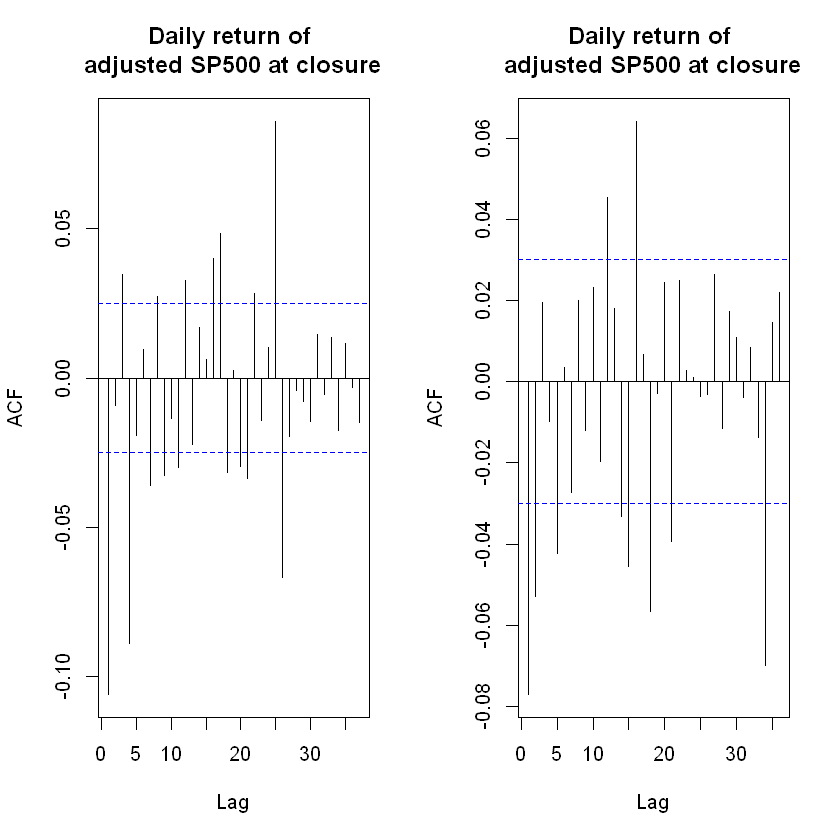

In [28]:
# More uncertainty in March-May and August-November Some more extremes early
# in the week

par(mfrow = c(1, 2))
title_sp <- "Daily return of \nadjusted SP500 at closure"
TSA::acf(spret, na.action = na.pass, main = title_sp)
TSA::acf(na.omit(as.vector(spret)), main = title_sp)

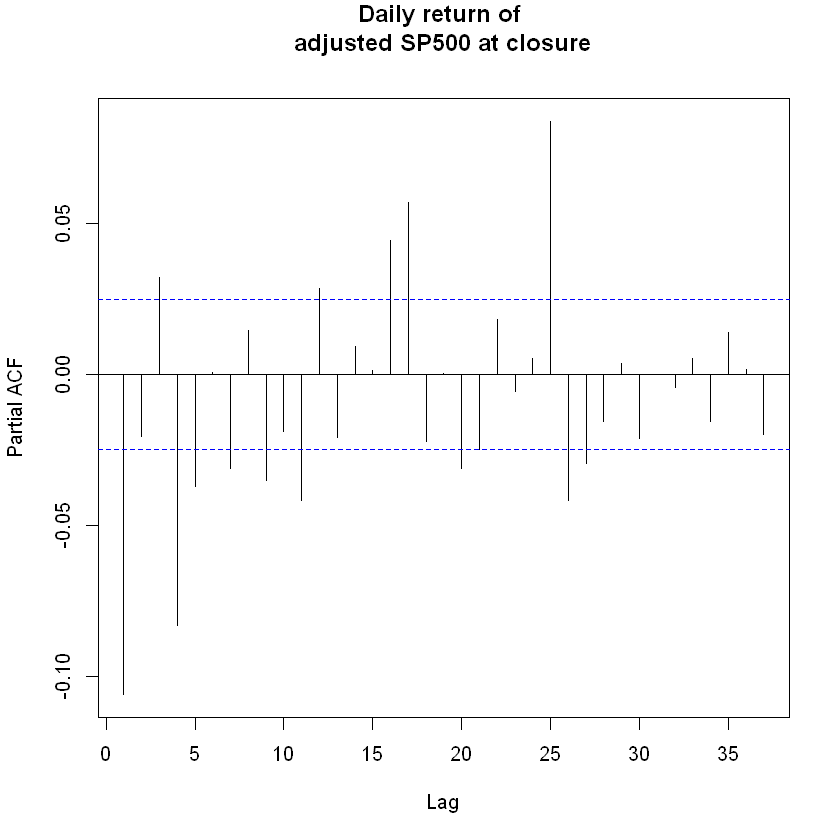

In [32]:
pacf(spret, na.action = na.pass, main = title_sp)


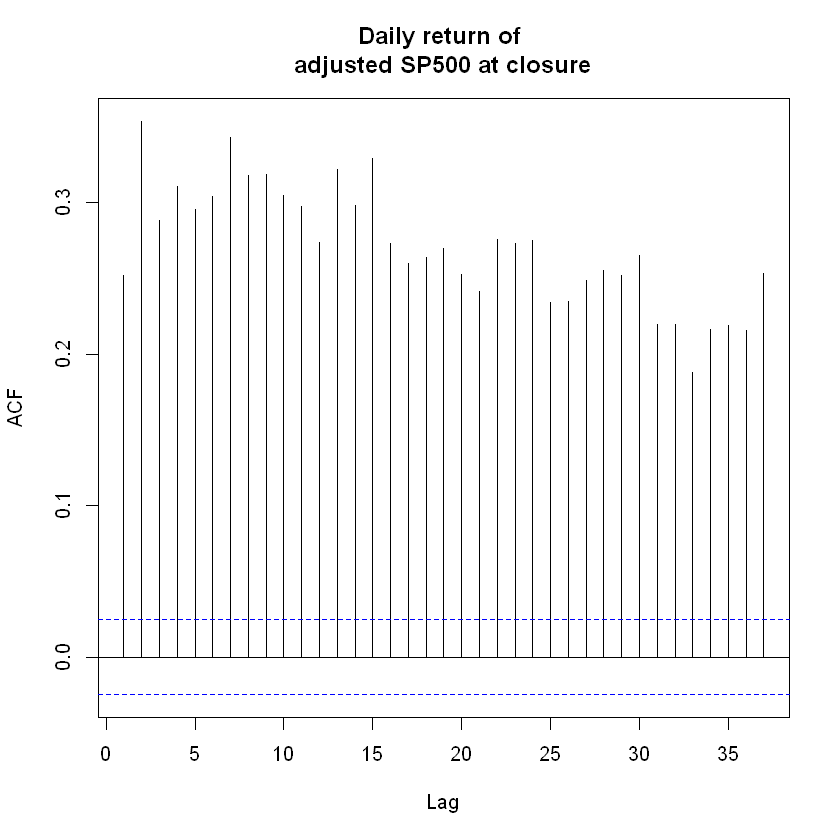

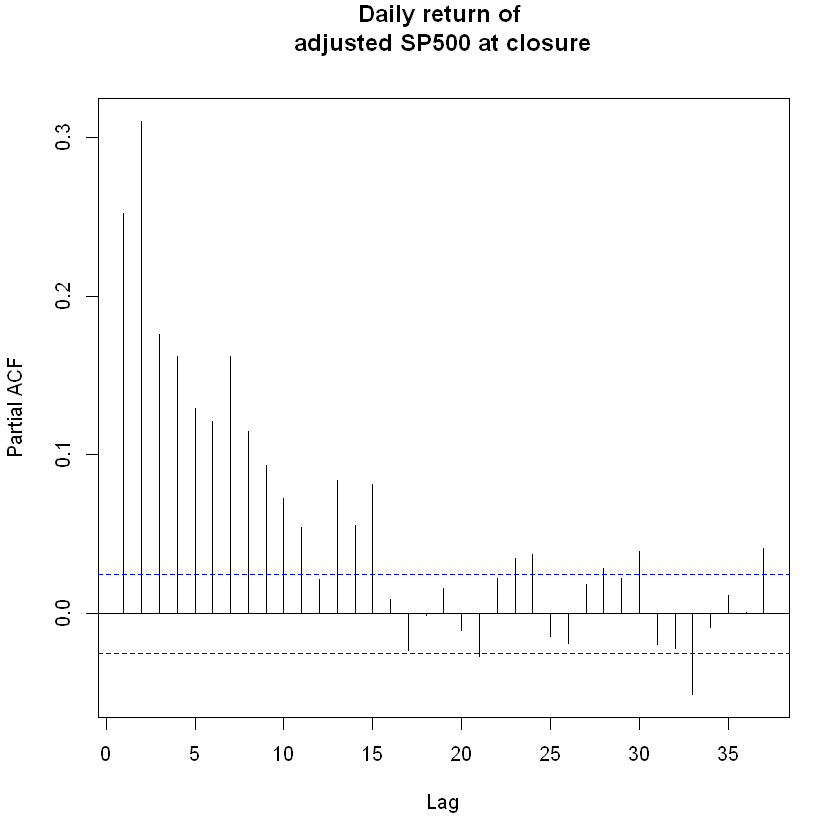

In [33]:
# (P)ACF of absolute value of daily returns
TSA::acf(abs(spret), na.action = na.pass, main = title_sp)
pacf(abs(spret), na.action = na.pass, main = title_sp)

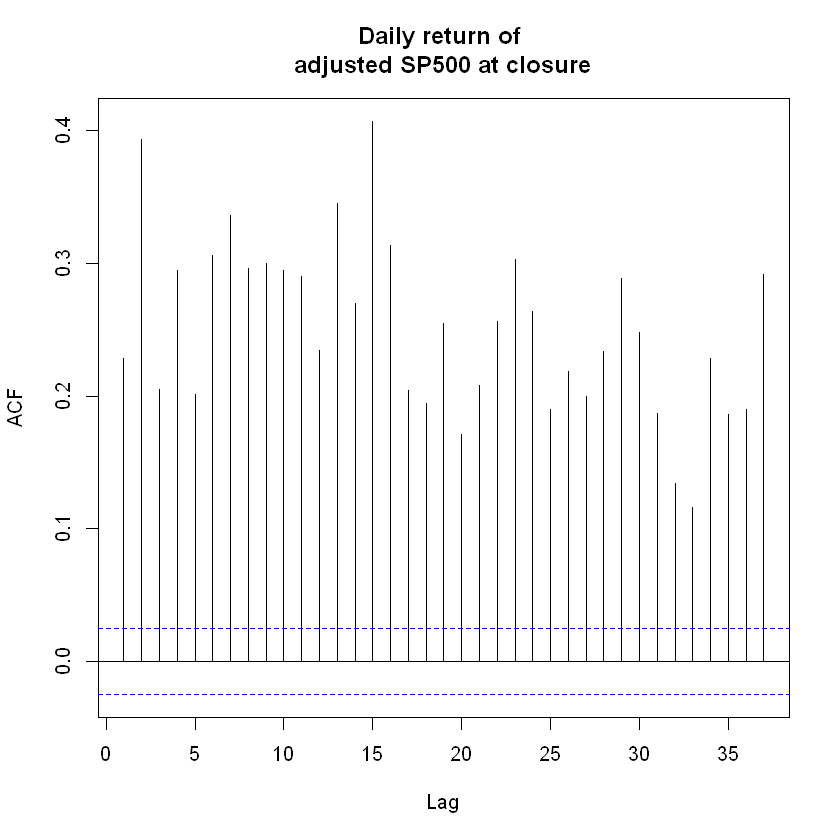

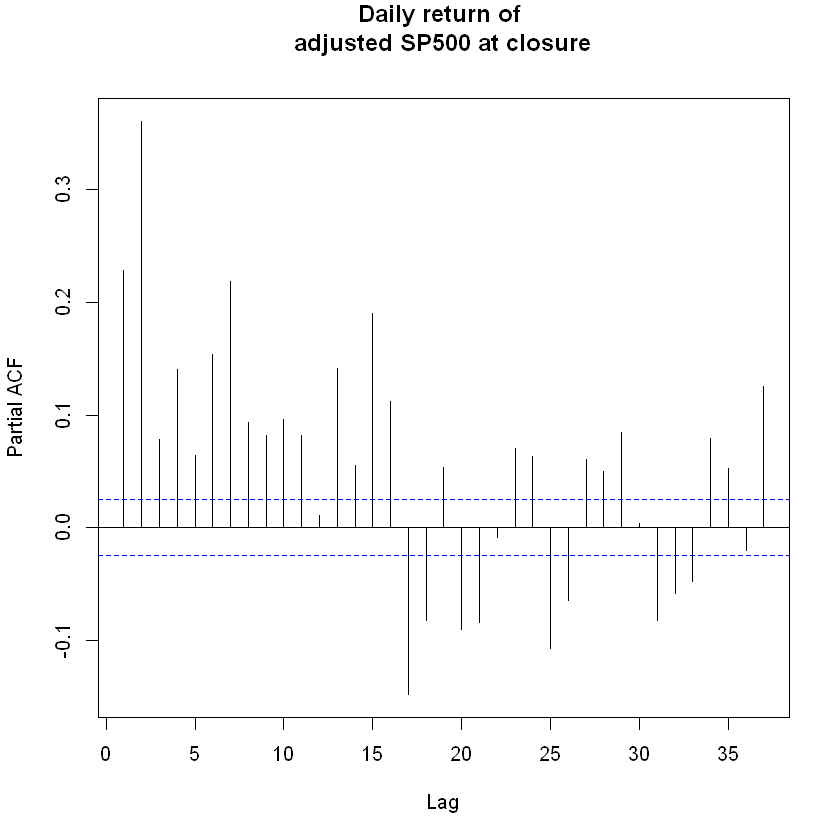

In [30]:
# (P)ACF of squared daily returns
TSA::acf(I(spret^2), na.action = na.pass, main = title_sp)
pacf(I(spret^2), na.action = na.pass, main = title_sp)